Cleaning the Data...
	We have 0.45% missing values so we drop them
Loading additional weather data...
Exploring K for KMeans for source coordinates...
Exploring K for KMeans for destination coordinates...
Performing K-means for both source and destination coordinates with K=15
Generating Cluster Map for source coordinates...
Generating Cluster Map for destination coordinates...
Starting Multivariate Time Series Analysis
	Plotting TS data and exporting to ./TS Decomposition/
	Exporting Time Series Decomposition to ./TS Decomposition/
	Testing if TS is stationary and exporting results to ./TS Decomposition//ADFtestResults.csv
Building model...
Loading model weights from Disk...
	Performance (RMSE) on Test Data is : 1281.150


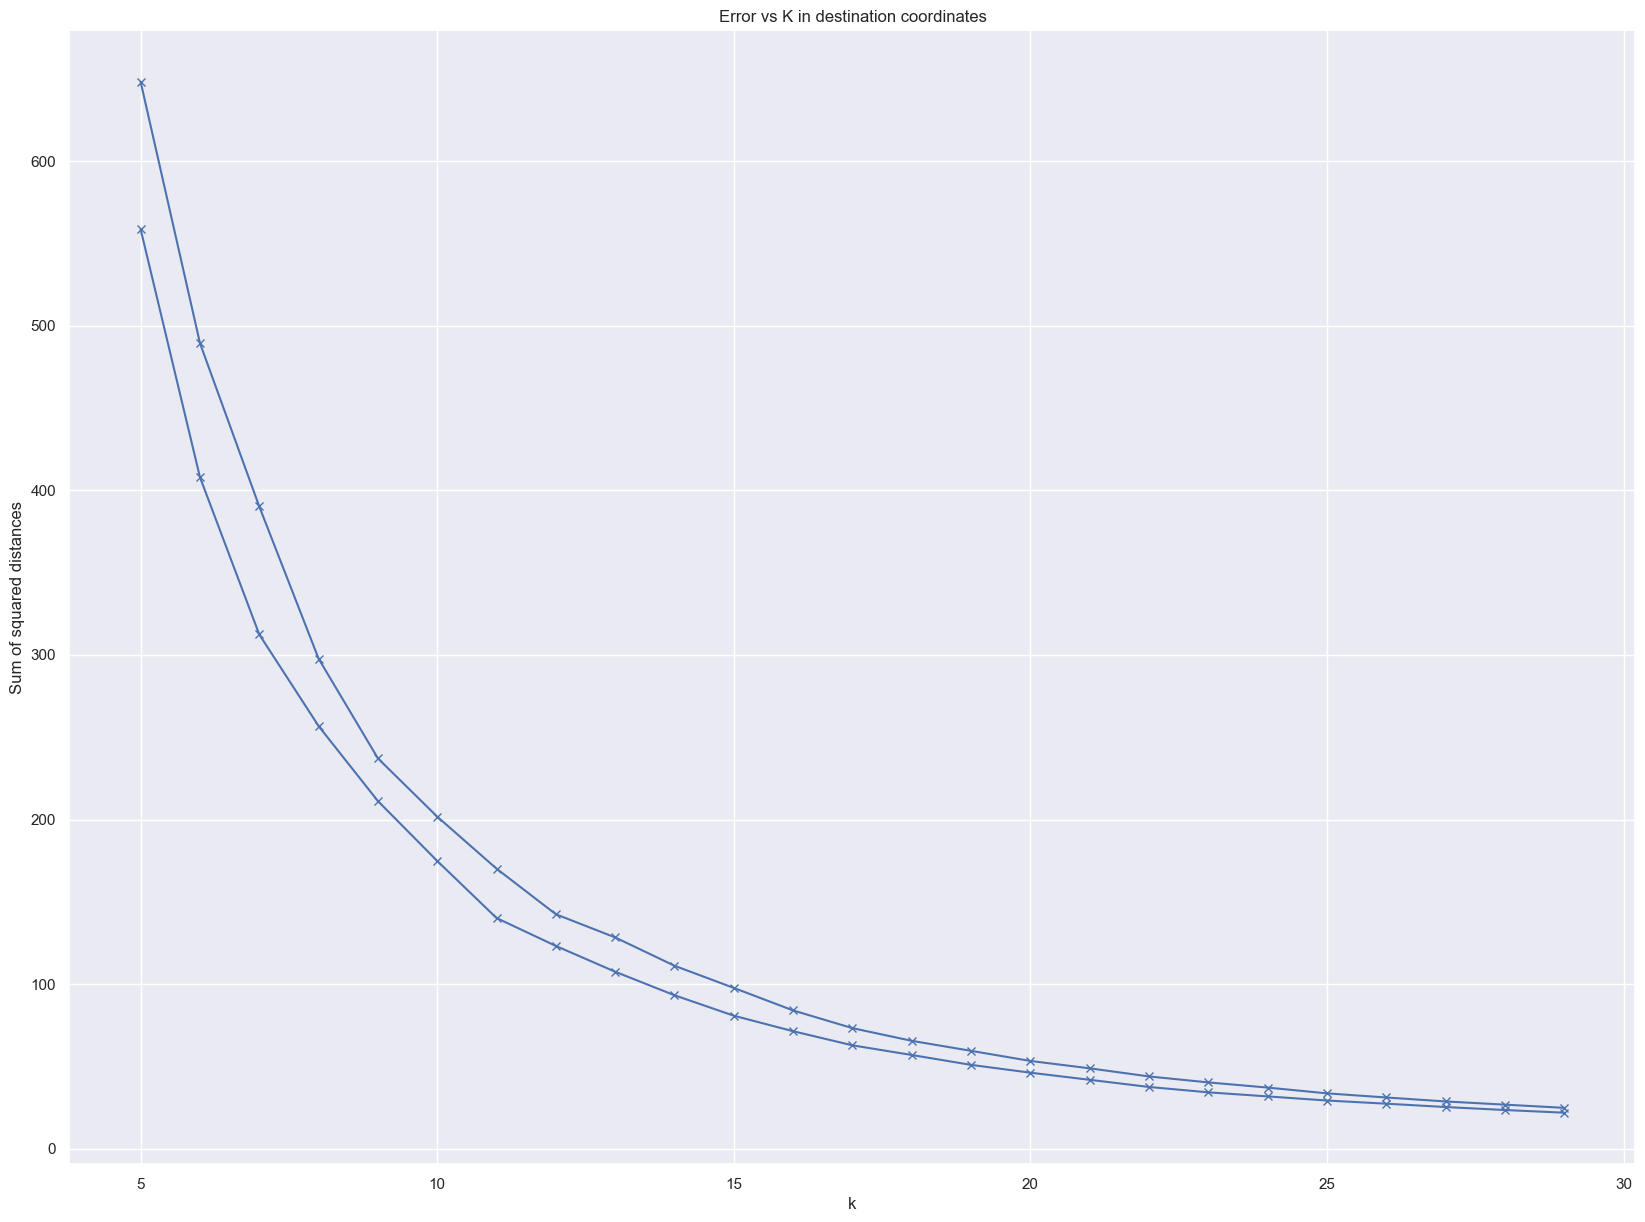

In [5]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pylab import rcParams
from sklearn.cluster import KMeans
from sklearn import metrics
import os
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import Sequential
from keras.layers import Dense, LSTM
import numpy as np
import pandas as pd
import seaborn as sns
import os


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

class DataLoader():
    def __init__(self, datapath='./routes.csv', weatherdata='./enrichment/lima_2015_weatherdata.csv'):
        self.datapath = datapath
        assert os.path.exists(self.datapath)
        self.__setmissingpath("./cleaning")
        self.__setweatherpath(weatherdata)                     # additional data to enrich the dataset
        df = pd.read_csv("./routes.csv", sep='\t')
                              
        df = self.cleanData(df)
        self.__setData(df)
        self.__setResampledData__(self.mergeWeatherData(df))           # after cleaning & merging
    
    def getData(self):
        return self.__data
    
    def getResampledData(self):
        return self.__resampledData
                              
    def getmissingpath(self):
        return self.__missingpath
    
    def getweatherpath(self):
        return self.__weatherdata
   
    def __setData(self, df):
        self.__data = df

    def __setResampledData__(self, df):
        self.__resampledData = df
        
    def __setmissingpath(self, path):
        self.__missingpath = path
        
    def __setweatherpath(self, path):
        self.__weatherdata = path
        
    def cleanData(self, df):
        print("Cleaning the Data...")
        sns.set(rc={'figure.figsize':(18,14), 'figure.dpi':100})
        sns_plot = sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
        bottom, top = sns_plot.get_ylim()                          # fix cropped axis problem
        sns_plot.set_ylim(bottom + 1.0, top - 1.0)
        
        if not os.path.exists(self.getmissingpath()):
            os.mkdir(self.getmissingpath())
        fig = sns_plot.figure.savefig(self.getmissingpath()+"/missingdata.png")
        #plt.figure(figsize=(14, 11), dpi=200)
        plt.close(fig)
        print("\tWe have "+str(np.around(len(df[df.isnull().any(axis=1)])/len(df)*100, decimals=3))+"% missing values so we drop them")    #def loadWeatherData(self):
        df = df.dropna()
        return df
      
    def loadWeatherData(self):
        """
        Hourly sampled dataset with temperature, wind and rain information
        """
        print("Loading additional weather data...")
        assert os.path.exists(self.getweatherpath())
        weatherdf = pd.read_csv(self.getweatherpath())
        return weatherdf
        
    def mergeWeatherData(self, df):
        dfw = self.loadWeatherData()
        #Resample df to a frequency of an hour
        df["request_date"]= pd.to_datetime(df["request_date"]) 
        df = df.resample('h', on = 'request_date').count()
        df = df.rename(columns={'passenger_id': 'requests'})
        df = df[['requests']]

        # Reset Indexes to merge
        df = df.reset_index()  
        dfw = dfw.reset_index()
        
        dfw['datetime'] = pd.to_datetime(dfw['datetime'])
        df = df.merge(dfw, left_on='request_date', right_on='datetime', how='left')
        df = df.fillna(df.mean())                                        # impute 6 missing values with mean
        df.drop(columns=['datetime', 'index'], inplace=True)                      # remove 2nd index
        
        # try to reindex
        df = df.set_index('request_date')
        df = df.asfreq(freq='h')    
        return df
        

class Cluster_Analysis():
    def __init__(self, df, clusterpath='./clustering', explore=False):
        self.__setClusterPath__(clusterpath) 
        self.__setData__(df)
        if explore!=False:
            self.clusterExploration(df, 'source')
            self.clusterExploration(df, 'destination')
        df = self.clusterData(df)
        self.drawClustersOnMap(df, 'source')
        self.drawClustersOnMap(df, 'destination')
    
    def getData(self):
        return self.__data
    
    def __setData__(self, df):
        self.__data = df
    
    def getClusterPath(self):
        return self.__clusterpath
                              
    def __setClusterPath__(self, path):
        self.__clusterpath = path 
                              
    def clusterExploration(self, df_geo, kind):
        performanceList = []
        K = range(5,30)
        """
        Trains K-means to the coordinates and exports elbow diagram to outputfolder
        Arguments:
            df: Input dataframe
            kind (string): 'source' or 'destination'
            outputfolder (string): folder to export elbow diagram
        Returns:
            data (pd.DataFrame): new dataframe with two new columns
            with the predicted source and destination based on the clustering
            algorithm
        """
        assert kind=='source' or kind=='destination'
        print("Exploring K for KMeans for "+str(kind)+" coordinates...")
        df_geo = df_geo[[str(kind)+'_longitude', str(kind)+'_longitude']]
        
        # Explore K
        for k in K:
            kmeanModel = KMeans(n_clusters=k, n_jobs=-1).fit(df_geo)
            performanceList.append(kmeanModel.inertia_)
            
        # Plot the elbow
        plt.plot(K, performanceList, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum of squared distances')
        plt.title('Error vs K in '+str(kind)+' coordinates')
        if not os.path.exists(self.getClusterPath()):
            os.mkdir(outputfolder)
        plt.savefig(self.getClusterPath()+'/elbow_rule_'+str(kind)+'.png')
        plt.close()
        
    def clusterData(self, df, k=15):                                    # default after elbow rule
        print("Performing K-means for both source and destination coordinates with K="+str(k))
        kmeans_model = KMeans(n_clusters=k, n_jobs=-1).fit(df[['source_latitude', 'source_longitude']])
        df['sourceCluster'] = kmeans_model.predict(df[['source_latitude', 'source_longitude']])

        kmeans_model = KMeans(n_clusters=k, n_jobs=-1).fit(df[['destination_latitude', 'destination_longitude']])
        df['destinationCluster'] = kmeans_model.predict(df[['destination_latitude', 'destination_longitude']])
        return df

    def calculateBoarders(self, df, decimals=4):
        # Needed to download Lima map from https://www.openstreetmap.org/export#map=5/51.500/-0.100

        sourceDict = {'longitude_max': np.around(df['source_longitude'].max(), decimals=decimals), 
                      'longitude_min': np.around(df['source_longitude'].min(), decimals=decimals), 
                      'latitude_max': np.around(df['source_latitude'].max(), decimals=decimals), 
                      'latitude_min': np.around(df['source_latitude'].min(), decimals=decimals)}

        destinationDict = {'longitude_max': np.around(df['destination_longitude'].max(), decimals=decimals), 
                      'longitude_min': np.around(df['destination_longitude'].min(), decimals=decimals), 
                      'latitude_max': np.around(df['destination_latitude'].max(), decimals=decimals), 
                      'latitude_min': np.around(df['destination_latitude'].min(), decimals=decimals)}
        
        
    def drawClustersOnMap(self, df, kind, photopath='./limaMap.png'):
        assert (kind=='source') or (kind=='destination')
        assert os.path.exists(photopath)
    
        print("Generating Cluster Map for "+str(kind)+" coordinates...")
        clusters = len(df[str(kind)+'Cluster'].unique())
        x = np.arange(clusters+1)                         # used for different colors of clusters
        ys = [i+x+(i*x)**2 for i in range(clusters+1)]
        colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(ys)))


        ruh_m = plt.imread(photopath)
        BBox = ((df[str(kind)+'_longitude'].min(),   
                 df[str(kind)+'_longitude'].max(),      
                 df[str(kind)+'_latitude'].min(), 
                 df[str(kind)+'_latitude'].max()))

        fig, ax = plt.subplots(figsize = (8,7))

        # For all Clusters
        num=0
        for k in df[str(kind)+'Cluster'].unique():
            ax.scatter(df[df[str(kind)+'Cluster']==k][str(kind)+'_longitude'], 
                       df[df[str(kind)+'Cluster']==k][str(kind)+'_latitude'], 
                       zorder=1, alpha= 0.2, c=[np.random.rand(3,)], s=10)                  # random color
        ax.set_title('Plotting Spatial Data on Lima Map')
        ax.set_xlim(BBox[0],BBox[1])
        ax.set_ylim(BBox[2],BBox[3])
        ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
        fig.savefig(str(self.getClusterPath())+'/Clustermap_'+str(kind)+'.png')
        plt.close(fig)



class TS_Analysis():    # add export of plots
    def __init__(self, df, exportpath='./TS Decomposition/'):
        print("Starting Multivariate Time Series Analysis")
        self.__setData__(df)
        self.__setExportPath__(exportpath)
        self.plotTS()
        self.TSDecomposition()  
        self.stationarityTests()
        
    def getExportPath(self):
        return self.__exportpath
        
    def __setData__(self, df):
        self.__data = df
        
        
    def __setExportPath__(self, exportpath):
        self.__exportpath = exportpath
        
    def getData(self):
        return self.__data
    
                    
    def plotTS(self):
        print("\tPlotting TS data and exporting to "+str(self.getExportPath()))
        df = self.getData()
        df.reset_index(inplace=True)
        fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
        figure = sns.lineplot(x='request_date', y='requests', color="indianred", data=df, ax=axs[0])
        for item in figure.get_xticklabels():
            item.set_rotation(45)
        figure = sns.lineplot(x='request_date', y='Temperature', color="blue", data=df, ax=axs[1])
        for item in figure.get_xticklabels():
            item.set_rotation(45)
        figure = sns.lineplot(x='request_date', y='Precipitation', color="green", data=df, ax=axs[2])
        for item in figure.get_xticklabels():
            item.set_rotation(45)
        figure = sns.lineplot(x='request_date', y='WindSpeed', color="black", data=df, ax=axs[3])
        for item in figure.get_xticklabels():
            item.set_rotation(45)
        plt.savefig(self.getExportPath()+"./plots.png")
        plt.close(fig)
                    
    def TSDecomposition(self):                                   # examine trend, seasonality
        rcParams['figure.figsize'] = 18, 8
        print("\tExporting Time Series Decomposition to "+str(self.getExportPath()))
        usefulcols = ['requests', 'Temperature', 'Precipitation', 'WindSpeed']  
        df = self.getData()
        for col in usefulcols:                           # do it for all relevant TS columns
            temp = df[['request_date', col]]
            temp = temp.set_index('request_date')
            temp = temp.asfreq(freq='h')
            
            decomposition = sm.tsa.seasonal_decompose(temp, model='additive')
            fig = decomposition.plot()
            fig.savefig(self.getExportPath()+str(col)+'_decomposition.png')
            plt.close(fig)

    
    def adf_test(self, timeseries):    # The more negative the Test Statistic is, the harder we reject H0: unit root/stationary
        #Perform Dickey-Fuller test:                 # equally: H0: TS is non-stationary
        dftest = adfuller(timeseries, autolag='AIC')
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        #print (dfoutput) 
        return dfoutput
    
    def stationarityTests(self):        # check for stationarity to determine whether its necessary to transform
        # In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, 
        # if the data is stationary, it will help with better performance and make it easier for the neural network 
        # to learn.
        print("\tTesting if TS is stationary and exporting results to "+str(self.getExportPath())+"/ADFtestResults.csv")
        df = self.getData()             # (log, boxcox) for forecasting
        df.drop(columns=['request_date'], inplace=True)
        dftest = pd.DataFrame()
        #usefulcols = [col for col in df.columns if col!='request_date']    # except the time index
        for col in df.columns:                # return all results for both tests and all TS in a dataframe
            dfadf = self.adf_test(df[col]) 
            row = pd.Series({'H0 Rejected':1 if dfadf.loc['p-value'] <= 0.05 else 0})   # result of the test
            dfadf = dfadf.append(row)    
            dftest[col,'ADF'] = dfadf
        dftest.to_csv(self.getExportPath()+"/ADFtestResults.csv")
        
        
class forecastModel():
    def __init__(self, df, exportpath='./model', testsize=0.2):  
        self.__setData__(df)
        self.__setTestSize__(testsize)
        self.__setExportPath__(exportpath)
        self.plotTimeSeries()
        self.preProcess(self.getData())
        self.buildModel()
        self.evaluatePlot()
    
    def getData(self):
        return self.__data
    
    def getExportPath(self):
        return self.__exportpath
    
    def getScaler(self):
        return self.__scaler
    
    def getTestSize(self):
        return self.__testSize
    
    def getModel(self):
        return self.__model
    
    def getInputShape(self):
        return self.__inputShape
    
    def getHistory(self):
        return self.__history
    
    def getTrainX(self):
        return self.__trainX
    
    def getTrainY(self):
        return self.__trainY
    
    def getTestX(self):
        return self.__testX
    
    def getTestY(self):
        return self.__testY
    
    def __setTestSize__(self, testsize):
        self.__testSize = testsize
    
    def __setData__(self, df):
        self.__data = df
        
    def __setInputShape__(self, input_shape):
        self.__inputShape = input_shape
        
    def __setProcessedDataSplits__(self, trainX, trainY, testX, testY):
        self.__trainX = trainX
        self.__trainY = trainY
        self.__testX = testX
        self.__testY = testY
        
    def __setModel__(self, model):
        self.__model = model
        
    def __setHistory__(self, history):
        self.__history = history
        
    def __setScaler(self, scaler):
        self.__scaler=scaler
        
    def __setExportPath__(self, exportpath):
        if not os.path.exists(exportpath):
            os.mkdir(exportpath)
        self.__exportpath = exportpath
    
    def plotTimeSeries(self):
        df = self.getData()
        train_size = int(len(df) * (1-self.getTestSize()))
        train, test = df[0:train_size], df[train_size:len(df)]
        plt.figure(figsize=(14, 14), dpi=200)
        plt.plot(train['requests'])
        plt.plot(test['requests'])
        plt.xticks(rotation=45)
        plt.savefig(self.getExportPath()+"/initialplots.png")
        plt.close()
    
    def preProcess(self, df):
        #print("Preprocess:")
        df = df.astype('float32')                   # NNs work better with small floats 
        
        # 0 - remove TS index
        df2 = df.reset_index()
        if 'request_date' in df2.columns:
            df2 = df2.drop(columns=['request_date'])
        if 'index' in df2.columns:
            df2 = df2.drop(columns=['index'])
        
        # 1 scale
        scaler = MinMaxScaler(feature_range=(0, 1))
        df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
        self.__setScaler(scaler)
        #df2.head()
        
        # 2 formulate as supervised ML - necessary for multivariate forecasting
        df2['label'] = df2['requests'].shift(-1)   # add next month's deposits as label!
        df2.dropna(inplace=True)                                 # last row has a null label! -> drop it
        
        # 3 split to train/set
        test_size = self.getTestSize()*len(df2)
        train_size = len(df2) - test_size
        labels = df2['label']
        df2.drop(columns=['label'], inplace=True)
        trainX, testX = df2.loc[0:train_size, :], df2.loc[train_size:len(df2),:]          # spit the features
        trainY, testY = labels.loc[0:train_size], labels.loc[train_size:len(labels)]      # split the labels

        # 4 reshape train arrays to numpy arrays
        trainX_array = np.array(trainX)
        trainY_array = np.array(trainY)
        trainX_array = trainX_array.reshape(trainX.shape[0], 1, trainX.shape[1])
        input_shape = trainX_array.shape
        self.__setInputShape__(input_shape)
        
        # 4 reshape test
        testX_array = np.array(testX)
        testY_array = np.array(testY)
        testX_array = testX_array.reshape(testX.shape[0], 1, testX.shape[1])
        
        # persist data!
        self.__setProcessedDataSplits__(trainX_array,
                                     trainY_array,
                                     testX_array,
                                     testY_array)
        
              
    
    def defineModel(self):
        # LSTM model 1
        input_shape = self.getInputShape()
        model = Sequential()                     # LSTM input layer MUST be 3D - (samples, timesteps, features)
        model.add(LSTM(50, activation='relu', 
                       return_sequences=True,  # necessary for stacked LSTM layers
                       input_shape=(input_shape[1], input_shape[2])))
        model.add(LSTM(50, activation='relu')) 
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        self.__setModel__(model)
        
    
    def trainModel(self):                                          # manually found best parameters
        print("Training model on TS data...")
        batch_size = 16
        epochs = 20
        model = self.getModel()
        history = model.fit(self.getTrainX(), self.getTrainY(), 
                                validation_data=(self.getTestX(), self.getTestY()),
                                epochs=epochs, batch_size=batch_size, 
                                verbose=1)
        # enforce model to disk (.h5)
        model.save_weights(self.getExportPath()+'/lstm.h5')
        self.__setHistory__(history)
        self.plotTrainHistory()
        self.__setModel__(model)
        
    def loadModel(self, path):
        # load from disk
        print("Loading model weights from Disk...")
        if os.path.exists(path):
            self.getModel().load_weights(path) 
            #self.__setModel__(model)
        
    def buildModel(self):
        print("Building model...")
        self.defineModel()
        if os.path.exists(self.getExportPath()+'/lstm.h5'):
            self.loadModel(self.getExportPath()+'/lstm.h5')
        else:
            self.trainModel()
        
        
    def plotTrainHistory(self):
        print("Exporting Train History...")
        history = self.getHistory()
        plt.figure(figsize=(9, 7), dpi=200)
        plt.plot(history.history["loss"], 'darkred', label="Train")
        plt.plot(history.history["val_loss"], 'darkblue', label="Validation")
        #plt.plot(history.history["val_loss"], 'darkblue', label="Test")
        plt.title("Loss over epoch")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(self.getExportPath()+'./LeaningCurves.png')
        plt.close()
        

    def evaluatePlot(self):
        model = self.getModel()
        trainX_array = self.getTrainX()
        testX_array = self.getTestX()
        scaler = self.getScaler()
        df = self.getData()
        
        trainPredict = np.array(model.predict(trainX_array))         # forecast based on training data
        testPredict = np.array(model.predict(testX_array))           # forecast of test (unseen data)
        
        testX_array = testX_array.reshape((testX_array.shape[0], testX_array.shape[2]))

        # invert scale for train forecast (train)
        trainX_array = trainX_array.reshape((trainX_array.shape[0], trainX_array.shape[2]))
        trainPredict = trainPredict.reshape((len(trainPredict), 1))
        inv_x = np.concatenate((trainPredict, trainX_array[:, 1:]), axis=1)
        inv_x = scaler.inverse_transform(inv_x)
        inv_x = inv_x[:,0]

        # invert scaling for forecast (test)   
        inv_yhat = np.concatenate((testPredict, testX_array[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]

        # invert scaling for actual values
        testY_array = self.getTestY()
        testY_array = testY_array.reshape((len(testY_array), 1))
        inv_y = np.concatenate((testY_array, testX_array[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]


        # calculate RMSE based on original-scaled data
        rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('\tPerformance (RMSE) on Test Data is : %.3f' % rmse)


        ### Merge inv_y with trainY_pred!
        wholeforecast = np.concatenate((inv_x, inv_yhat), axis=0)
        len(wholeforecast)

        # Plot against original data
        fig, ax1 = plt.subplots(figsize=(14,11))
        ax1.plot(np.array(df['requests']), label='Actual Requests')
        ax1.plot(wholeforecast, label = 'Forecasted Requests')
        plt.axvline(x=(1-self.getTestSize())*len(df), label='train/test split', c='k')
        ax1.set_title('Requests vs Time')
        ax1.set_ylabel('Requests')
        ax1.set_xlabel('hours')
        L=ax1.legend() #create and get the legend
        plt.savefig(self.getExportPath()+'/actualVSpredicted.jpg')
        plt.close()
    

    
    
def main(cluster=True):
    loader = DataLoader()
    resampledData = loader.getResampledData()
    if cluster:
        Cluster_Analysis(loader.getData(), explore=True)
    TS_Analysis(resampledData)
    model = forecastModel(resampledData)
    
    
if __name__== "__main__":
    main()